In [1]:
# Imports
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Constants
NSHARDS = 10
RESULTS_DIR = '/tmp/mwe'
LOCALDIR = '/tmp'

ENCODERS = ['GCN', 'GAT']
TRAINING_SCHEMES = ['JL', 'PF', 'URL']
# SSL_METHODS = ['SUBGCON', 'GraphInfoClust','DeepGraphInfomax','MERIT', 'GBT', 'SelfGNNPPR', 'BGRL','GCA', 'PairwiseAttrSim', 'CentralityScoreRanking', 'AttributeMask']
SSL_METHODS = ['G_Zoom']

METRIC = 'test_rocauc_ovr'

In [3]:
dfs = []
for shard_idx in range(NSHARDS):
  filename = 'results.ndjson-%s-of-%s' % (str(shard_idx).zfill(5), str(NSHARDS).zfill(5))
  print(filename)

  with open(f'{RESULTS_DIR}/{filename}', 'r') as f:
    lines = f.readlines()
    records = map(json.loads, lines)
    dfs.append(pd.DataFrame.from_records(records))

# Construct df and remove nans
results_df = pd.concat(dfs)
results_df.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
results_df.dropna(axis=0, inplace=True)
del dfs

results.ndjson-00000-of-00010


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/mwe/results.ndjson-00000-of-00010'

In [4]:
results_df

,nvertex,avg_degree,feature_center_distance,feature_dim,edge_center_distance,edge_feature_dim,p_to_q_ratio,num_clusters,cluster_size_slope,power_exponent,...,APPNP_SUBGCON_URL_encoder_alpha,APPNP_SUBGCON_URL_encoder_iterations,APPNP_SUBGCON_URL_encoder_dropout,APPNP_SUBGCON_URL_encoder_out_channels,APPNP_SUBGCON_URL_pretext_alpha,APPNP_SUBGCON_URL_pretext_k,APPNP_SUBGCON_URL_pretext_losses,APPNP_SUBGCON_URL_downstream_val_losses,APPNP_SUBGCON_URL_downstream_train_losses,APPNP_SUBGCON_URL_downstream_val_tuning_metrics
0,170,9.360947,2.358237,16,2.0,2,60.499372,4,0.98017,3.0,...,0.2,15,0.3,4,0.1,5,"[0.9986165761947632, 0.9983866214752197, 0.998...","[1.5287269353866577, 1.523766851425171, 1.5188...","[1.4552555084228516, 1.453266978263855, 1.4512...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ..."


In [4]:
def get_cells(dataframe: pd.DataFrame, encoder:str = "", ssl_method:str = "", training_scheme:str = "", other:str = ""):
    cols = [col for col in dataframe if (encoder in col and ssl_method in col 
                                         and training_scheme in col and other in col)]
    return dataframe[cols]
    

In [5]:
get_cells(results_df, training_scheme="PF", other="train")

In [6]:
def plot_learning_curve(df: pd.DataFrame, training_scheme:str, encoder:str, ssl_method:str):
    metrics = ["pretext_losses", "downstream_train_losses", "downstream_val_losses", "downstream_val_tuning_metrics"]
    colors = ["r","g","b","purple"]
    fig, axes = plt.subplots(1, 4, figsize=(15, 2))
    for idx, m in enumerate(metrics):
        cell = get_cells(df, encoder=encoder, training_scheme=training_scheme, ssl_method=ssl_method, other=m).iloc[0,0]
        axes[idx].plot(cell, label=f'{encoder}_{ssl_method}_{training_scheme}_{m}', c=colors[idx])
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=4, fancybox=True, shadow=True)
    fig.show()

In [7]:
for ts in TRAINING_SCHEMES:
    plot_learning_curve(df = results_df, training_scheme = ts, encoder="GCN", ssl_method=SSL_METHODS[0])


NameError: name 'results_df' is not defined

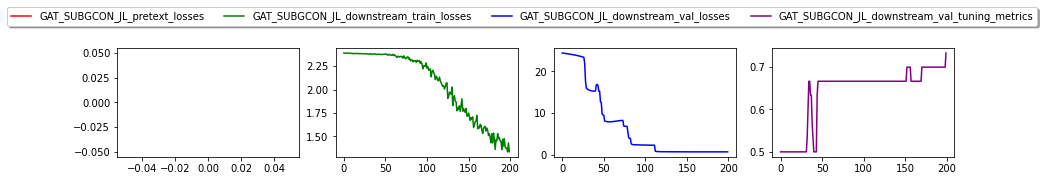

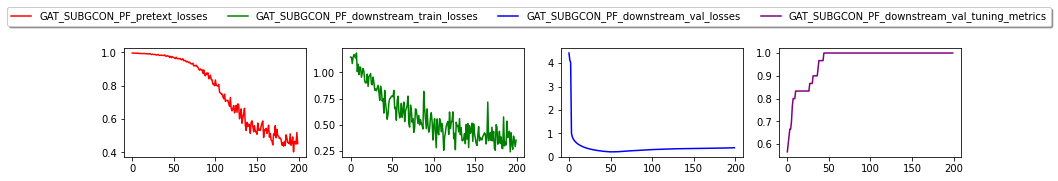

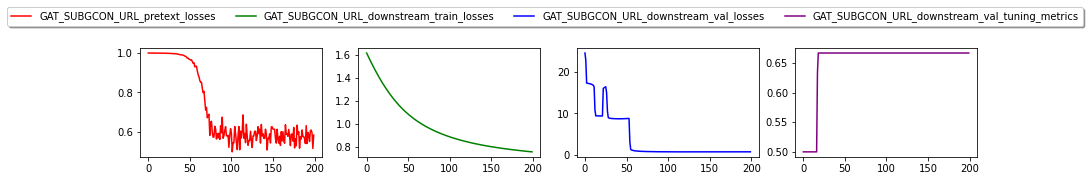

In [9]:
for ts in TRAINING_SCHEMES:
    plot_learning_curve(df = results_df, training_scheme = ts, encoder="GAT", ssl_method=SSL_METHODS[0])

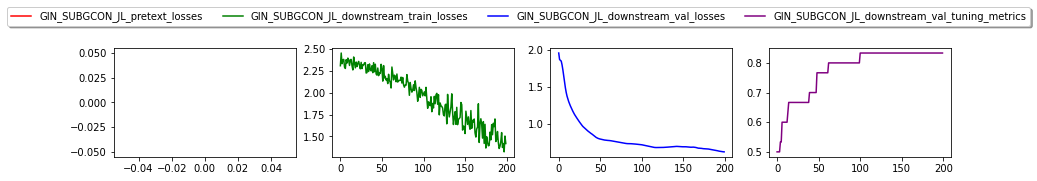

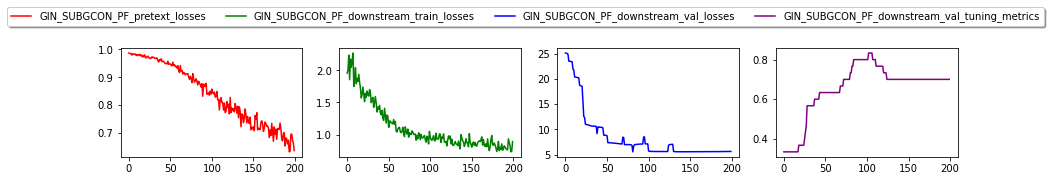

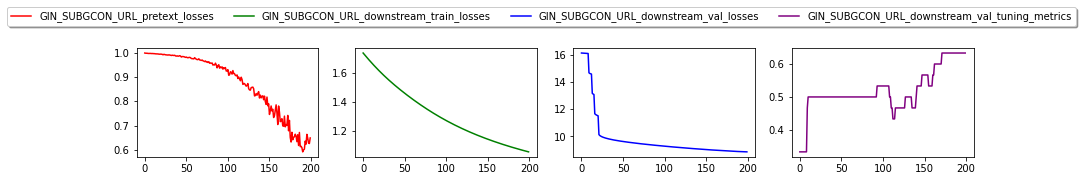

In [10]:
for ts in TRAINING_SCHEMES:
    plot_learning_curve(df = results_df, training_scheme = ts, encoder="GIN", ssl_method=SSL_METHODS[0])

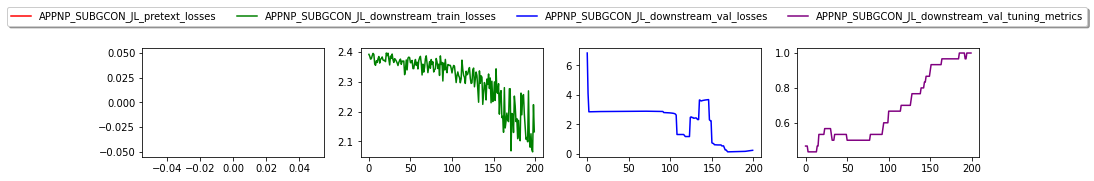

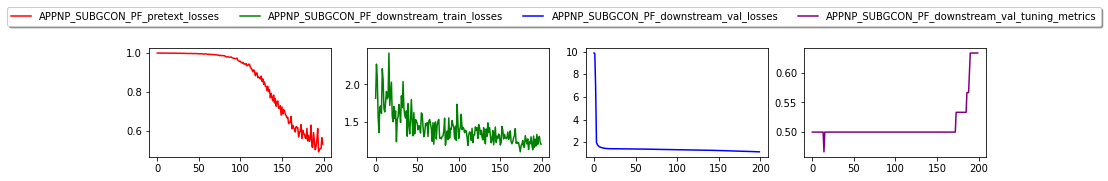

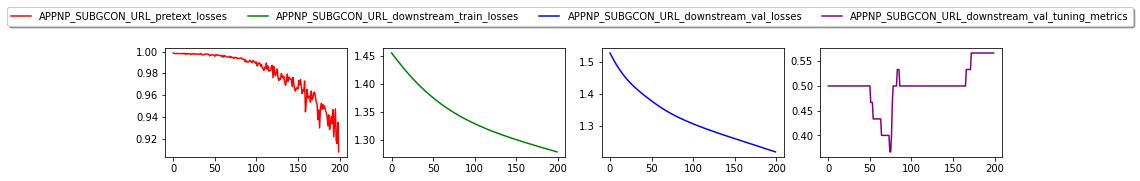

In [11]:
for ts in TRAINING_SCHEMES:
    plot_learning_curve(df = results_df, training_scheme = ts, encoder="APPNP", ssl_method=SSL_METHODS[0])

In [12]:
# Function for 1D lineplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

def bucket_response_surface1d(results_df, xvar, metric='test_accuracy',
                              group=False, ngrid=25, custom_range=None):
  # BAD_VALS = [np.nan, np.inf, -np.inf]
  # results_df_inner = results_df[~results_df.isin(BAD_VALS).any(1)]
  results_df_inner = results_df.copy(deep=True)
  if custom_range is None:
    min_xvar = np.min(results_df_inner[xvar])
    max_xvar = np.max(results_df_inner[xvar])
  else:
    min_xvar = custom_range[0]
    max_xvar = custom_range[1]
  xrange = np.linspace(min_xvar, max_xvar, ngrid)
  def convert_value(z, range):
    return range[np.argmin(np.abs(range - z))]
  results_df_inner[xvar] = results_df_inner[xvar].apply(convert_value,
                                                        range=xrange)
  if group:
    return results_df_inner.groupby([xvar])[[xvar, metric]].mean()
  else:
    return results_df_inner

def plot_response_surface1d(param, metric, results_df,
                            models=MODELS,
                            reverse_x=False, ci=99):
  bucketed_dfs = []
  index_pos = 0
  grouped_index_pos = 0
  grouped_bucketed_dfs = []
  for model in models:
    model_metric = '%s_%s' % (model, metric)
    if model_metric not in results_df.columns:
      continue

    # Get and store ungrouped bucketed df
    bucketed_df = bucket_response_surface1d(results_df, param,
                                            metric=model_metric,
                                            group=False)
    bucketed_df = bucketed_df.rename(columns={model_metric: metric})
    bucketed_df['model'] = model
    new_index = list(range(index_pos, index_pos + bucketed_df.shape[0]))
    bucketed_df.index = new_index
    bucketed_dfs.append(bucketed_df)
    index_pos += bucketed_df.shape[0]

    # Get and store grouped bucketed df
    grouped_bucketed_df = bucket_response_surface1d(results_df, param,
                                                    metric=model_metric,
                                                    group=True)
    grouped_bucketed_df = grouped_bucketed_df.rename(
        columns={model_metric: metric})
    grouped_bucketed_df['model'] = model
    grouped_new_index = list(range(
        grouped_index_pos, grouped_index_pos + grouped_bucketed_df.shape[0]))
    grouped_bucketed_df.index = grouped_new_index
    grouped_bucketed_dfs.append(grouped_bucketed_df)
    grouped_index_pos += grouped_bucketed_df.shape[0]

    
    
  plot_df = pd.concat(bucketed_dfs, axis=0)

  # Make the plot
  fig = plt.figure(figsize=(10, 10))

  range_x = (np.min(results_df[param]), np.max(results_df[param]))
  if reverse_x:
    range_x = (range_x[1], range_x[0])

  sns.lineplot(data=plot_df, x=param, y=metric, hue="model", ci=ci)
  plt.title('%s vs %s' % (metric, param))
  plt.show()

NameError: name 'MODELS' is not defined

In [7]:
results_df

,nvertex,avg_degree,feature_center_distance,feature_dim,edge_center_distance,edge_feature_dim,p_to_q_ratio,num_clusters,cluster_size_slope,power_exponent,...,GCN__test_rocauc_ovo,GCN__test_logloss,GCN__train_epochs,GCN__train_lr,GCN__train_lambda,GCN__model_in_channels,GCN__model_hidden_channels,GCN__model_num_layers,GCN__model_dropout,GCN__model_out_channels
0,209,10.899522,3.492671,16,2.0,2,22.221548,4,0.011599,3.0,...,0.599011,7.875098,100,0.0010,0.010,16,4,4,0.0,4
0,225,9.733334,3.158847,16,2.0,2,50.454397,4,0.469266,3.0,...,0.684683,1.210218,100,0.0010,0.001,16,4,2,0.0,4
0,376,10.224000,3.940170,16,2.0,2,31.935628,4,0.007042,3.0,...,0.500000,17.403789,100,0.0001,0.100,16,8,2,0.8,4
0,497,12.443548,1.045569,16,2.0,2,39.164808,4,0.496077,3.0,...,0.956830,1.258061,100,0.0100,10.000,16,4,1,0.0,4
0,331,10.308157,1.027807,16,2.0,2,2.569559,4,0.411158,3.0,...,0.500000,17.479501,100,0.0001,0.001,16,4,1,0.3,4
0,281,12.469751,4.209970,16,2.0,2,15.307312,4,0.016430,3.0,...,0.946697,0.812750,100,0.0100,10.000,16,4,2,0.0,4
0,318,9.465409,1.019629,16,2.0,2,22.591605,4,0.630220,3.0,...,0.960115,0.821925,100,0.0100,0.100,16,16,4,0.5,4
0,153,10.130719,3.534509,16,2.0,2,28.795572,4,0.252313,3.0,...,1.000000,0.182065,100,0.0100,1.000,16,8,1,0.0,4
0,194,11.195876,2.374508,16,2.0,2,8.771916,4,0.069010,3.0,...,0.749111,1.421592,100,0.0010,0.100,16,16,4,0.0,4
0,231,12.761905,2.016350,16,2.0,2,5.594774,4,0.104855,3.0,...,0.969082,0.799181,100,0.0010,0.001,16,16,1,0.0,4


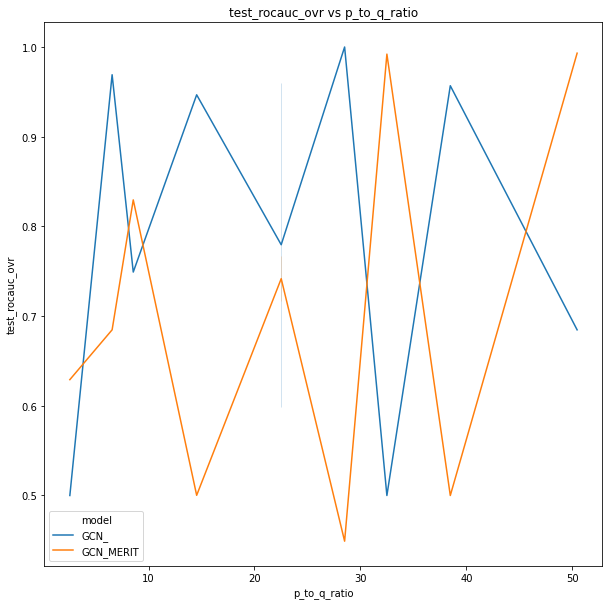

In [8]:
plot_response_surface1d('p_to_q_ratio', METRIC, results_df)